In [70]:
# Based on "The Metrics Manifesto" by Richard Seiersen, Chapter 3 - from ABC (Approximate Bayes Computation) to Canonical Bayes.
# The author used R code, and here's my attempt to "translate" his reasoning and R code to Python.

from scipy.stats import binom
from empiricaldist import Pmf
import numpy as np
import pandas as pd
import seaborn as sns

# variables
sim_phish = 1000000 # number of campaign simulations
campaign_size = 1000 # number of emails in each campaign
df = pd.DataFrame() # create empty dataframe

# get prior_rate, round each result
df['prior_rates'] = [round(test,2) for test in (np.random.uniform(0,1,sim_phish))]

In [71]:
df

,prior_rates
0,0.08
1,0.37
2,0.57
3,0.27
4,0.97
...,...
999995,0.52
999996,0.17
999997,0.32
999998,0.93


In [72]:
# Each prior_rate (P) results is equally likely (around 3-3.5%) to happen - be it 4% or 78% or 99% - which is of course, not very real. - histogram
# parameters to histplot: stat = "density" shows density of the results P - flat line close to 1 means equally plausible, stat = "probability" will turn Y axis into P of each test;
# default histplot Y is count.

<Axes: ylabel='Density'>

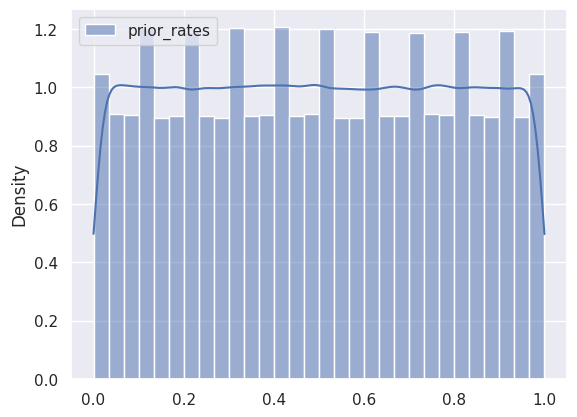

In [73]:
sns.set(color_codes=True)
sns.histplot(df, bins=30, stat="density",kde=True)

<Axes: ylabel='Probability'>

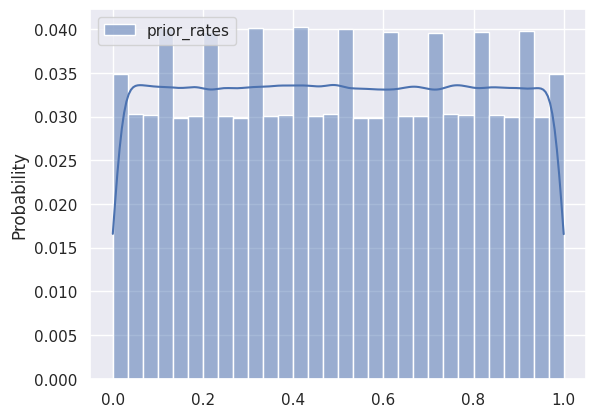

In [74]:
sns.histplot(df, bins=30, stat="probability",kde=True)

<Axes: ylabel='Count'>

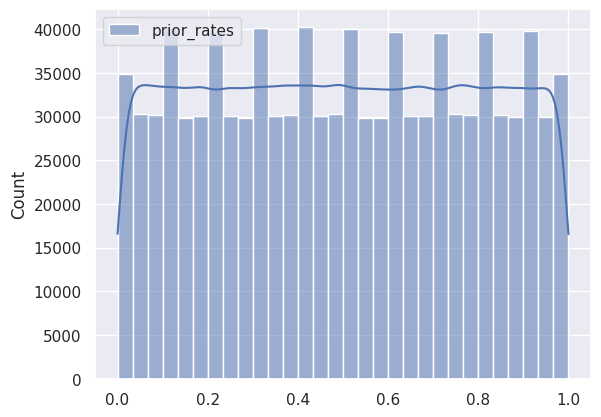

In [75]:
sns.histplot(df, bins=30,kde=True)

In [76]:
# now add another column to the dataset called "phish_chance"
df['phish_chance'] = "NA"

In [77]:
df.head()

,prior_rates,phish_chance
0,0.08,NA
1,0.37,NA
2,0.57,NA
3,0.27,NA
4,0.97,NA


In [82]:
# Now score prior_rates with Phish campaigns using random binomial distribution parametrized with campaign_size and prior_rate (p)
list_of_chances =  [Pmf.from_seq(np.random.binomial(1,size=campaign_size,p=x)).to_list() for x in df['prior_rates']]
df['phish_chance'] = [1-x.pop(0) for x in list_of_chances]

In [79]:
df.head()

,prior_rates,phish_chance
0,0.08,0.061
1,0.37,0.392
2,0.57,0.606
3,0.27,0.280
4,0.97,0.962


<Axes: xlabel='phish_chance', ylabel='Count'>

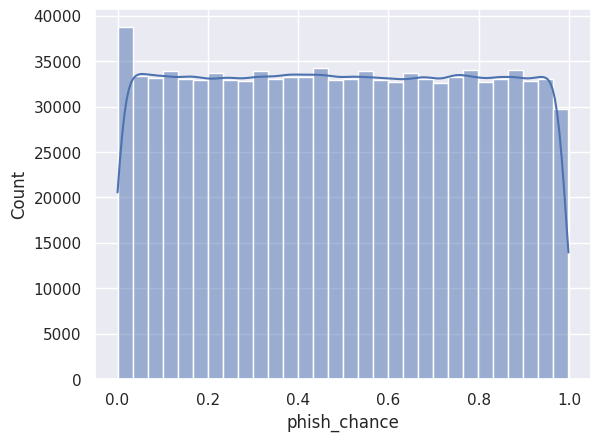

In [80]:
sns.histplot(df['phish_chance'], bins=30,kde=True)

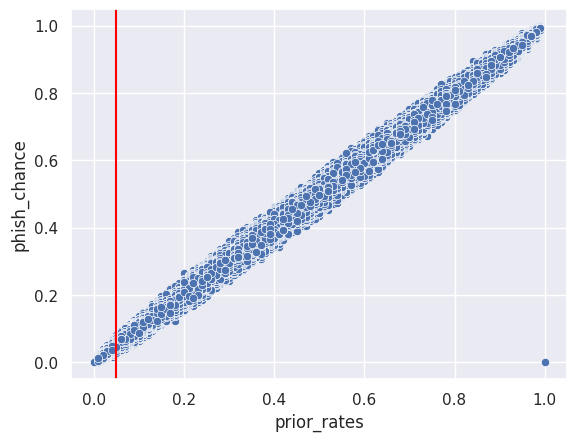

In [81]:
# The scatterplot shows clear correlation between the two series.The red line shows the cluster with up to 5% chances for phishing - this is our belief !
# As we do not think all are equally plausible, only these up to 5% - like, it may happen only in 5 emails in 100 if its send to our users.
import matplotlib.pyplot as plt

sns.scatterplot(df, x=df['prior_rates'],y=df['phish_chance'])
plt.axvline(x=0.05, color="red")

In [85]:
uptofive =  ((df.phish_chance <=0.05) & (df.phish_chance > 0.001))

In [86]:
df_posterior = df[uptofive].prior_rates

In [87]:
df_posterior.head()

7     0.02
24    0.01
35    0.02
64    0.02
68    0.02
Name: prior_rates, dtype: float64

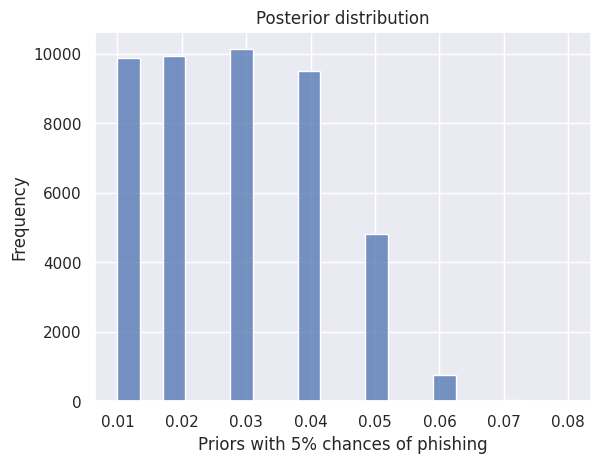

In [88]:
# In the region of up to 5% phish, here is the histogram of the most likely numbers 
ax = sns.histplot(df_posterior, bins=20,kde=False)
ax.set(xlabel='Priors with 5% chances of phishing', ylabel='Frequency', title='Posterior distribution')
plt.show()

In [89]:
# The below number mean that phishing clicks baseline rate exists between 1%-8% - between 1 and 8 clicks per 100 emails.
# with 95% credibility interval (2.5% at the lower bound and 2.5% at the upper bound.
np.quantile(df_posterior, 0.025)

0.01

In [90]:
np.quantile(df_posterior, 0.975)

0.05

<Axes: xlabel='new_prior_rates', ylabel='Probability'>

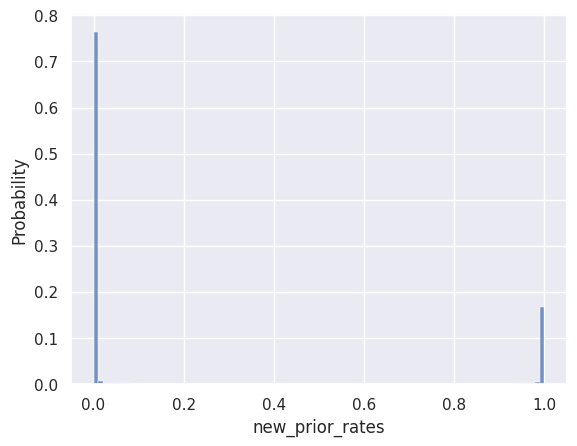

In [96]:
# Now, you show these results to CISO or someone else who's a security expert in your local user community, and he says it's waaay to much - he didn't see more than 5%
# It's close to 4%, yes - between 1 and 4% seems Ok. So, now these informative priors need to be applied to our beliefs and get the model updated.
# We'll use Beta distribution Beta(X) where  0 < X < 1, and a = 0.01, b = 0.04
df['new_prior_rates'] = np.random.beta(0.01,0.04, size=sim_phish)
sns.histplot(df['new_prior_rates'], bins=100, stat='probability')

In [92]:
# And now, go from the beginning again..

In [97]:
# now add another column to the dataset called "phish_chance"
df['new_phish_chance'] = "NA"

In [98]:
# Now score prior_rates with Phish campaigns using random binomial distribution parametrized with campaign_size and prior_rate (p)
list_of_chances =  [Pmf.from_seq(np.random.binomial(1,size=campaign_size,p=x)).to_list() for x in df['new_prior_rates']]
df['new_phish_chance'] = [1-x.pop(0) for x in list_of_chances]

In [99]:
uptofive =  ((df.new_phish_chance <=0.05) & (df.new_phish_chance > 0))
df_new_posterior = df[uptofive].new_prior_rates
df_new_posterior.head()

17     0.003547
19     0.000867
24     0.002221
111    0.002972
124    0.001217
Name: new_prior_rates, dtype: float64

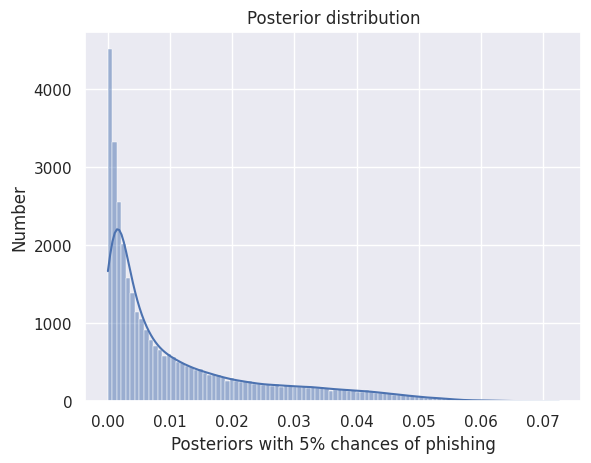

In [100]:
# In the region of up to 5% phish, here is the histogram of the most likely numbers 
ax = sns.histplot(df_new_posterior, bins=100,kde=True)
ax.set(xlabel='Posteriors with 5% chances of phishing', ylabel='Number', title='Posterior distribution')
plt.show()

In [101]:
np.quantile(df_posterior, 0.05)

0.01

In [102]:
np.quantile(df_posterior, 0.95)

0.05

In [275]:
# The last plot can be interpreted to "The most probable P of phish within the interval of 1-7% is around 1%. Or in 5 clicks in 100 emails will happen with about 1% chance.


<Axes: xlabel='new_prior_rates', ylabel='Probability'>

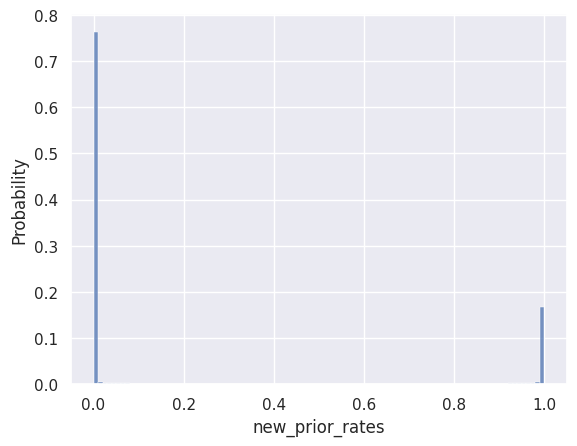

In [105]:
# test another way to get beta distribution with random
import random
df['new_prior_rates'] = [random.betavariate(0.01, 0.04) for i in range(sim_phish)]
sns.histplot(df['new_prior_rates'], bins=100, stat='probability')

In [106]:
# Continued -----> from ABC to canonical Bayes, prior = 5/100, to uninformed prior (uniform cdf) -> posterior
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
import seaborn as sns

clicks = 5
emails = 100
phish_grid = [x for x in np.arange(0,1,0.0001)]
arr = binom.pmf(clicks,emails,phish_grid)

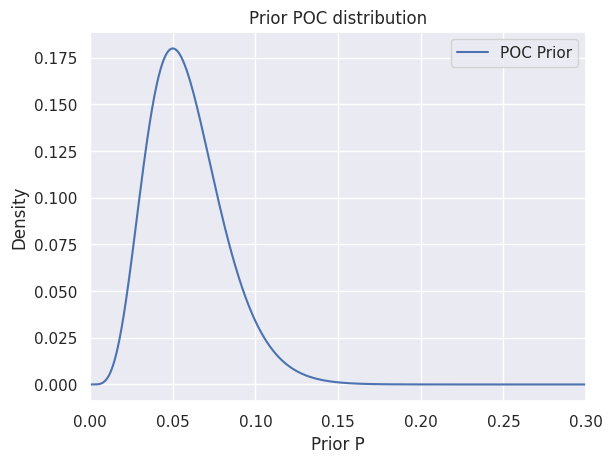

In [107]:
ax=sns.lineplot(x=phish_grid,y=arr, label='POC Prior')
ax.set_xlim(0.0, 0.3)
ax.set(xlabel='Prior P', ylabel='Density', title='Prior POC distribution')
plt.show()

In [109]:
# Likelihood of the data 
from scipy.stats import uniform
arr_uni = uniform.cdf(phish_grid,0,1)

In [110]:
# Multiply POC Priors by likelihood of the data
import pandas as pd
df_new = pd.DataFrame() # create empty dataframe
df_new['binom'] = arr
df_new['uni'] = arr_uni
df_new['posterior'] = df_new['binom']*df_new['uni']

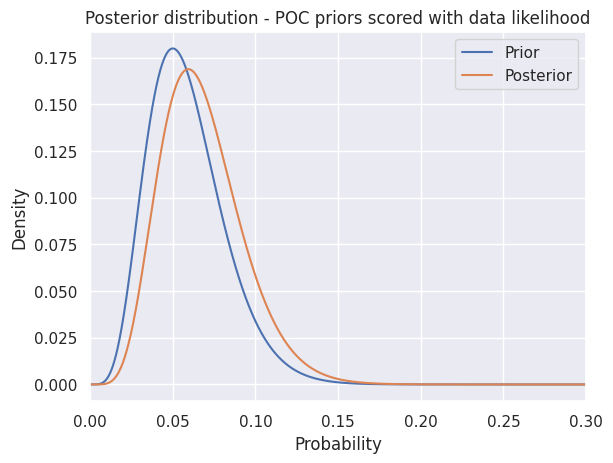

In [111]:
ax = plt.subplot()
sns.lineplot(x=phish_grid,y=arr, label='Prior')
sns.lineplot(x=phish_grid,y=(100*df_new['posterior']/sum(df_new['posterior'])), label='Posterior')
ax.set_xlim(0.0,0.3)
ax.set(xlabel='Probability', ylabel='Density', title='Posterior distribution - POC priors scored with data likelihood')
plt.show()

In [67]:
# This way we can verify our initial priors taken from POC (that 5 out of 100 phishing emails gets clicked)
# with some observables here simulated with the likelihood of the data. So ultimately the posterior P is actually closer to 6%